# TMA4320 / TFY4215 - Våren 2019 , Prosjekt 2
## Endimensjonale modeller for atomer, molekyler og krystaller
**Gruppe 4, Mads Adrian Simonsen**

## Oppgave 1

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# Stiller inn ønsket parameter for figurer
fontsize = 12
newparams = {'axes.titlesize': fontsize, 'axes.labelsize': fontsize,
             'lines.linewidth': 1.5, 'lines.markersize': 12,
             'figure.figsize': (10, 4), 'ytick.labelsize': fontsize,
             'xtick.labelsize': fontsize, 'legend.fontsize': fontsize,
            'legend.handlelength': 1.5, 'figure.autolayout': True}

hBar = 1.0545718e-34 # Planck const
m = 9.10938e-31 # mass of electron
e = 1.60217733e-19 # Coulomb, elementary charge
V0 = -1.2e-16# Potential energy
w = 65e-12 # 65 picometers, width of well
b = 10e-12 # 10 picometers, distance between atoms in molecule/crystall
N = 1000 # Number of elements

In [2]:
'''
Denne funksjonen tar inn antall potensialbrønner,
og returnerer Energiegenverdiene, de normaliserte bølgefunksjonene, x-verdiene, og lengden på x-aksen
'''
def eigenvalue_eigenvector(N_w, full_computation=True):
    L = N_w*w + 2*10*w + (N_w - 1)*b
    DeltaX = L/(N+1) # Delta x
    x = np.linspace(0, L, N+2)
    c = -hBar**2/(2*m * DeltaX**2)
    d = -2*c * np.ones(N) # the diagonal elements of the array
    e = c * np.ones(N-1) # the off-diagonal elements of the array
    update_diagonal(d, N_w, L)
    
    # Bruker scipy sin eigh_tridiagonal for å hente ut egenverdiene E, og egenvektorene psi
    E, psi = eigh_tridiagonal(d, e)
    if full_computation:
        normalize_vectors(psi, DeltaX) # Normerer psi
        sign_correction(psi) # psi starter alltid stigende
    return E, psi, x[1:-1], L

In [3]:
# Denne funksjonen oppdaterer hoveddiagonalen til Hamilton-matrisen før vi benytter eigh_tridiagonal 
def update_diagonal(d, N_w, L):
    if N_w % 2 and N_w > 0:
        d[int(np.rint(N/L * (L-w)/2 )) : int(np.rint(N/L * (L+w)/2 ))] += V0
        for i in range(N_w//2):
            d[int(np.rint(N/L * ((L+w)/2+b+i*(w+b)) )) : int(np.rint(N/L * ((L+w)/2+b+i*(w+b)+w) ))] += V0
            d[int(np.rint(N/L * ((L-w)/2-b-w-i*(w+b)) )) : int(np.rint(N/L * ((L-w)/2-b-i*(w+b)) ))] += V0
    elif N_w > 0:
        for i in range(N_w//2):
            d[int(np.rint(N/L * ((L+b)/2+i*(w+b)) )) : int(np.rint(N/L * ((L+b)/2+i*(w+b)+w) ))] += V0
            d[int(np.rint(N/L * ((L-b)/2-i*(w+b)-w) )) : int(np.rint(N/L * ((L-b)/2-i*(w+b)) ))] += V0

# Denne funksjonen normerer bølgefunksjonen slik at integralet fra 0 til L av |psi(x)|^2 blir 1
def normalize_vectors(psi, DeltaX):
    for i in range(N):
        psi[:,i] = psi[:,i] / np.sqrt(DeltaX * np.sum(psi[:,i]**2))

# Denne funksjonen sørger for at psi alltid starter med positivt stigningstall
def sign_correction(psi):
    for i in range(N):
        if psi[0,i] < 0:
            psi[:,i] = -1 * psi[:,i]
        elif psi[0,i] == 0:
            idx = 1
            value = 0
            while value == 0:
                value = psi[idx,i]
                if value < 0:
                    psi[:,i] = -1 * psi[:,i]
                idx +=1

In [4]:
def analytic(x, L):
    E_analytic = np.zeros(N)
    psi_analytic = np.zeros((N, N))
    for i in range(N):
        k_i = (i+1) * np.pi/L
        E_analytic[i] = hBar**2 * k_i**2 / (2*m)
        psi_analytic[:,i] = np.sqrt(2/L) * np.sin((i+1)*np.pi * x / L)
    return E_analytic, psi_analytic

In [5]:
def plot1():
    plt.rcParams.update(newparams)
    plt.subplot(1, 2, 1)
    plt.title(r"Numeriske løsninger på $\psi_\mathrm{i}(x)$, i = 1, 2, 3")
    plt.plot(x, psi[:, 0], label="$\psi_1(x)$")
    plt.plot(x, psi[:, 1], label="$\psi_2(x)$")
    plt.plot(x, psi[:, 2], label="$\psi_3(x)$")
    plt.axhline(0, linewidth=0.5, color='black')
    plt.xticks([0, L],
              ['0', r'$x = L$'])
    plt.yticks([-np.sqrt(2/L), 0, np.sqrt(2/L)],
              [r'$-\sqrt{2/L}$', r'0', r'$\sqrt{2/L}$'])
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title(r"Analytiske løsninger på $\psi_\mathrm{i}(x)$, i = 1, 2, 3")
    plt.plot(x, psi_a[:, 0], label="$\psi_1(x)$")
    plt.plot(x, psi_a[:, 1], label="$\psi_2(x)$")
    plt.plot(x, psi_a[:, 2], label="$\psi_3(x)$")
    plt.axhline(0, linewidth=0.5, color='black')
    plt.xticks([0, L],
              ['0', r'$x = L$'])
    plt.yticks([-np.sqrt(2/L), 0, np.sqrt(2/L)],
              [r'$-\sqrt{2/L}$', r'0', r'$\sqrt{2/L}$'])
    plt.legend(loc='best')
    
    plt.show()

In [6]:
def plot2():
    width = 10
    height = 4
    plt.figure(figsize=(width, height))
    n = 1 + np.arange(10)
    plt.title("Plott av beregnede og analytiske energinivåer")
    plt.plot(n, E_a[:n.size]/e, 'r.', label='Analytisk')
    plt.plot(n, E[:n.size]/e, 'b+', label='Numerisk')
    plt.legend(loc='best')
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.xlabel('Kvantetall n')
    plt.ylabel(r'Energiegenverdi $E_\mathrm{n}$ [eV]')
    plt.show()

Under så ser vi 3 plotvindu. Her kan vi se på de to første plottene at de tre første numeriske bølgefunksjone stemmer godt overens med de analytiske bølgefunksjonene som er gitt ved
$$
    \psi_j(x) = \sqrt{2/L}\sin k_j x, \quad k_j = j\pi/L, \quad j = 1, 2, 3 \dots.
$$

Det samme kan vi si om det tredje plottet. De 10 første numeriske energiegenverdiene stemmer meget bra med den analytiske løsningen
$$
    E_j = \frac{\hbar^2 k_j^2}{2m}.
$$

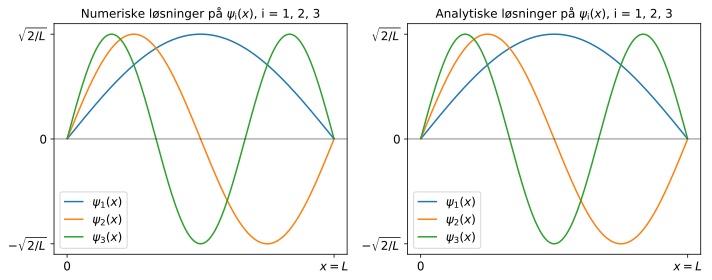

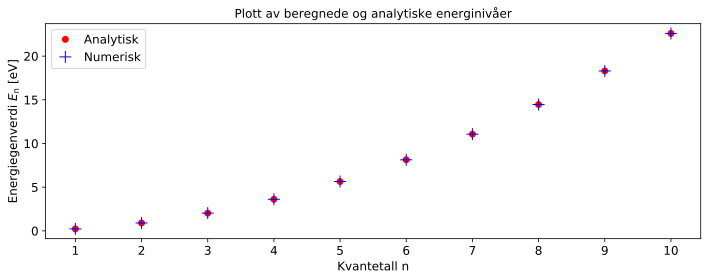

In [7]:
E, psi, x, L = eigenvalue_eigenvector(0) # Numerical solutions

E_a, psi_a = analytic(x, L) # Analytic solutions

plot1()
plot2()

In [8]:
def orthonormal_check():
    ort_mat = np.zeros((N, N))
    DeltaX = L/(N+1)
    for i in range(N):
        ort_mat[i,i] = DeltaX*np.sum(psi[:,i]*psi[:,i])
        for j in range(i+1, N):
            elem = DeltaX*np.sum(psi[:,i]*psi[:,j])
            ort_mat[i,j], ort_mat[j,i] = elem, elem
    np.set_printoptions(precision=3)
    print("Sjekker at egenfunksjonene er ortonormale:\n", ort_mat, '\n')

def complete_set_check():
    com_mat = np.zeros((N, N))
    DeltaX = L/(N+1)
    for i in range(N):
        com_mat[i,i] = DeltaX*np.sum(psi[i,:]*psi[i,:])
        for j in range(i+1, N):
            elem = DeltaX*np.sum(psi[i,:]*psi[j,:])
            com_mat[i,j], com_mat[j,i] = elem, elem
    np.set_printoptions(precision=3)
    print("Sjekker at egenfunksjonene danner et fullstendig sett:\n", com_mat, '\n')

orthonormal_check()
complete_set_check()

Sjekker at egenfunksjonene er ortonormale:
 [[ 1.000e+00  8.652e-16  7.472e-16 ...  1.690e-17 -9.525e-18 -2.612e-18]
 [ 8.652e-16  1.000e+00 -1.927e-15 ...  1.290e-17  7.989e-18 -3.380e-18]
 [ 7.472e-16 -1.927e-15  1.000e+00 ... -7.374e-18  4.179e-17  1.321e-17]
 ...
 [ 1.690e-17  1.290e-17 -7.374e-18 ...  1.000e+00 -3.146e-16  1.180e-16]
 [-9.525e-18  7.989e-18  4.179e-17 ... -3.146e-16  1.000e+00  1.573e-15]
 [-2.612e-18 -3.380e-18  1.321e-17 ...  1.180e-16  1.573e-15  1.000e+00]] 

Sjekker at egenfunksjonene danner et fullstendig sett:
 [[ 1.000e+00  5.506e-16  4.523e-16 ...  4.947e-17 -2.953e-16  1.638e-16]
 [ 5.506e-16  1.000e+00  5.113e-16 ... -1.880e-16  2.581e-17 -2.277e-16]
 [ 4.523e-16  5.113e-16  1.000e+00 ...  2.704e-16  4.025e-16  6.882e-17]
 ...
 [ 4.947e-17 -1.880e-16  2.704e-16 ...  1.000e+00  3.933e-16  2.163e-16]
 [-2.953e-16  2.581e-17  4.025e-16 ...  3.933e-16  1.000e+00  2.360e-16]
 [ 1.638e-16 -2.277e-16  6.882e-17 ...  2.163e-16  2.360e-16  1.000e+00]] 



Programmet ser ut til å virke bra så langt. Over kan vi se to matriser hvor den første viser at alle n = 1000 bølgefunksjonene er ortonormale, mens den andre matrisen viser at bølgefunksjonene danner et fullstendig sett. Dette ser vi ved at diagonalen i begge matrisene gir 1, og resten tilnærmet 0.

Matrisene er representert på følgende måte:

$$
\left[
\begin{matrix}
    \psi^{(1)}\psi^{(1)} & \psi^{(1)}\psi^{(2)} & \dots  & \psi^{(1)}\psi^{(n)} \\
    \psi^{(2)}\psi^{(1)} & \psi^{(2)}\psi^{(2)} & \dots  & \psi^{(2)}\psi^{(n)} \\
    \vdots               & \vdots               & \ddots & \vdots \\
    \psi^{(n)}\psi^{(1)} & \psi^{(n)}\psi^{(2)} & \dots  & \psi^{(n)}\psi^{(n)} \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
    \psi_{1}\psi_{1} & \psi_{1}\psi_{2} & \dots  & \psi_{1}\psi_{n} \\
    \psi_{2}\psi_{1} & \psi_{2}\psi_{2} & \dots  & \psi_{2}\psi_{n} \\
    \vdots           & \vdots           & \ddots & \vdots \\
    \psi_{n}\psi_{1} & \psi_{n}\psi_{2} & \dots  & \psi_{n}\psi_{n} \\
\end{matrix}
\right]
\approx
\left[
\begin{matrix}
    1 & 0 & \dots  & 0 \\
    0 & 1 & \dots  & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots  & 1 \\
\end{matrix}
\right].
$$.


## Oppgave 2

In [9]:
def plot3():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    sl = 350 # slice
    plt.title(r"3 bundne tilstander i en endelig brønn")
    plt.plot((L*sl/N, (L - w)/2), (0,0), 'k-')
    plt.plot(((L + w)/2, L*(1 - sl/N)), (0,0), 'k-')
    plt.plot(((L - w)/2, (L + w)/2), (V0,V0), 'k-')
    plt.plot(((L - w)/2, (L - w)/2), (V0,0), 'k-')
    plt.plot(((L + w)/2, (L + w)/2), (V0,0), 'k-')
    plt.plot(x[sl:-sl], (psi[sl:-sl, 2]/1.2e22)+E[2], label="$\psi_3(x)$")
    plt.plot(x[sl:-sl], (psi[sl:-sl, 1]/1.2e22)+E[1], label="$\psi_2(x)$")
    plt.plot(x[sl:-sl], (psi[sl:-sl, 0]/1.2e22)+E[0], label="$\psi_1(x)$")
    plt.axhline(0, linewidth=0.5, color='black')
    plt.axhline(E[0], linewidth=0.5, color='red')
    plt.axhline(E[1], linewidth=0.5, color='red')
    plt.axhline(E[2], linewidth=0.5, color='red')
    plt.xlabel(r'$x$ [ pm ]')
    plt.ylabel(r'Potensialet $V(x)$ [eV]')
    plt.xticks([5.0e-10, 6.0e-10, 7.0e-10, 8.0e-10, 9.0e-10], [500, 600, 700, 800, 900])
    plt.yticks([V0, E[0], E[1], E[2], 0],
              [r'$V_0$', r'$E_1$', r'$E_2$', r'$E_3$', 0])
    plt.legend(loc='right')
    
    plt.show()

In [10]:
def plot4():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    xi = np.linspace(1/(N+1), N/(N+1), N)
    f = np.tan(xi*np.sqrt(m*w**2*np.abs(V0)/(2*hBar**2)))
    sym = np.sqrt(1-xi**2)/xi
    asym = -xi/np.sqrt(1-xi**2)
    tol = 3.5
    f[np.abs(f) > tol] = np.nan
    sym[np.abs(sym) > tol] = np.nan
    asym[np.abs(asym) > tol] = np.nan
    
    
    # Her finner vi krysningspunktene mellom funksjonene vi ser i plottet under
    a = f - sym
    b = f - asym
    number_of_roots = 3
    idx = np.zeros(number_of_roots)
    incr = 0
    for i in range(N-1):
        if a[i] * a[i+1] < 0:
            idx[incr] = i if np.abs(a[i]) < np.abs(a[i+1]) else i+1
            incr += 1
        if b[i] * b[i+1] < 0:
            idx[incr] = i if np.abs(b[i]) < np.abs(b[i+1]) else i+1
            incr += 1
    idx = np.int64(idx)
    E_a = V0*(1 - xi[idx]**2) # Computed energies from precise continuous functions
    
    
    # Tilbake til plottet
    plt.subplot(1, 2, 1)
    plt.title("Grafisk løsning av energiverdilikningen")
    plt.axhline(0, linewidth=1, color='black')
    plt.plot(xi, f, label=r'$\tan\left(\xi\sqrt{\frac{m w^2 (0 - V_0)}{2 \hbar^2}}\right)$')
    plt.plot(xi, sym, 'm--', label=r'$\frac{\sqrt{1-\xi^2}}{\xi}$, symm. $\psi$')
    plt.plot(xi, asym, 'g--', label=r'$-\frac{\xi}{\sqrt{1-\xi^2}}$, asym. $\psi$')
    plt.plot(xi[idx], f[idx], 'r.')
    plt.xlabel(r'$\xi = \sqrt{\frac{E-V_0}{0-V_0}}$')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title("Beregnede og analytiske energinivåer")
    k = 1 + np.arange(3)
    plt.plot(k, E_a/e, 'r.', label=r'$E_\mathrm{analytisk}$')
    plt.plot(k, E[:3]/e, 'b+', label=r'$E_\mathrm{numerisk}$')
    plt.xticks([1, 2, 3], [1, 2, 3])
    plt.xlabel("Kvantetall n")
    plt.ylabel(r'Energiegenverdi $E_\mathrm{n}$ [eV]')
    plt.legend()
    
    plt.show()
    
    print("3 første kvantiserte energinivåene (numerisk):  ", E[:3]/e, "eV")
    print("3 første kvantiserte energinivåene (analytisk): ", E_a/e, "eV")
    print("Relativt avvik i prosent: ", 100*np.abs(E_a-E[:3])/-E_a)

In [11]:
def plot5():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    
    k = 1 + np.arange(50)
    plt.title(r'Kvantisert spekter for $E<0$ og "kvasikontinuerlig" spekter for $E>0$')
    plt.axhline(0, linewidth=0.5, color='black')
    plt.plot(k, E[:k.size]/e, 'r.', label=r'$E_\mathrm{n}$')
    plt.xlabel('Kvantetall n')
    plt.ylabel(r'$E_\mathrm{n} \rightarrow E(n)$ [eV]')
    plt.legend(loc='best')
    plt.show()

### a)
Vi har satt verdiene $V_0 = -0.12$ fJ $\approx -748.98$ eV, og $w = 65$ pm, slik at atomet har 3 bundne tilstander. Under ser vi et plott av dei tre tilstandene til atomet. Egenskapene stemmer godt overens med teorien. Første bølgefunksjon har ca. 1/2 bølgelengde innenfor det klassisk tillate området, mens andre og tredje bølgefunksjon har respektivt 1, og 3/2 bølgelengder innenfor. Vi ser også at bølgefunksjonene krummer bort fra deres respektive energinivå-akser i utenfor brønnen, mens de krummer mot aksen innenfor.

For å kunne sammenligne energinivåene med analytiske løsninger, må vi ta i bruk en grafisk løsniing av energiverdilikningen som ser slik ut:

$$
    \tan\left(\xi\sqrt{\frac{mw^2(0-V_0)}{2\hbar^2}}\right) =
    \
    \begin{cases} 
      \frac{\sqrt{1-\xi^2}}{\xi} & \text{symmetriske $\psi$} \\
      -\frac{\xi}{\sqrt{1-\xi^2}} & \text{antisymmetriske $\psi$}
   \end{cases},
   \quad
   \xi = \sqrt{\frac{\text{kinetisk energi}}{\text{brønnhøyden}}} = \sqrt{\frac{E-V_0}{0-V_0}}.
$$

Denne likningen er løst grafisk, hvor vi har markert de 3 krysningspunktene i plottet under, og løst for $E$.
Resultatet stemmer godt overens med energinivåene som er løst numerisk, med avvik på høyest 2,5 %.

Det siste plottet i denne bolken viser at energinivåene først er kvantisert for de 3 bundne tilstandene, for deretter å ligge tett i tett sammen når $E_j>0$.

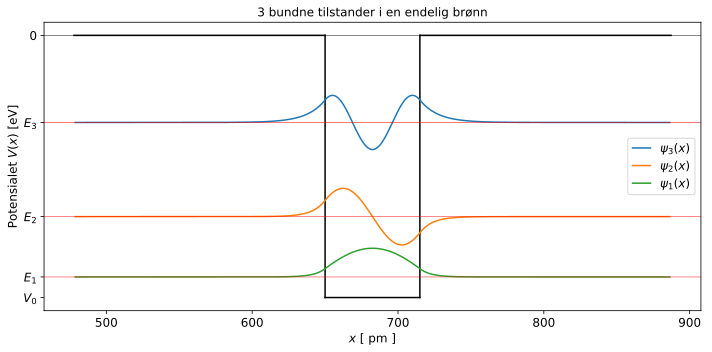

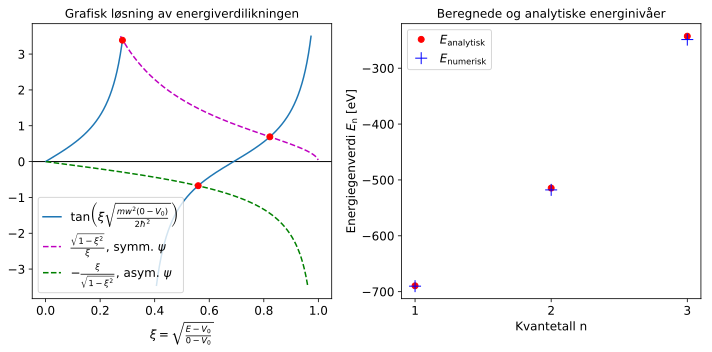

3 første kvantiserte energinivåene (numerisk):   [-690.201 -517.812 -248.792] eV
3 første kvantiserte energinivåene (analytisk):  [-689.538 -514.569 -242.687] eV
Relativt avvik i prosent:  [0.096 0.63  2.515]


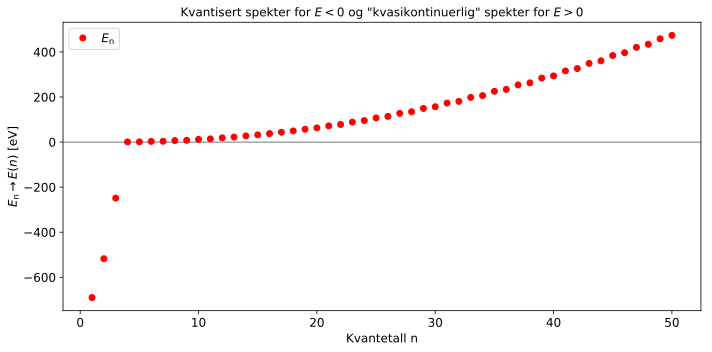

In [12]:
E, psi, x, L = eigenvalue_eigenvector(1) # Numerical solutions
plot3()
plot4()
plot5()

lambda_11(utenfor):  3.25 Å
lambda_11(innenfor): 0.45 Å

Kinetisk energi beregnet ved lambda_11:
K_utenfor:  14.28 eV
K_innenfor: 742.78 eV

Numerisk:
K_utenfor:  E_11 - 0  = 14.27 eV
K_innenfor: E_11 - V0 = 763.25 eV

Avvik:
Avvik på K_utenfor: 0.06 %
Avvik på K_innenfor: 2.68 %


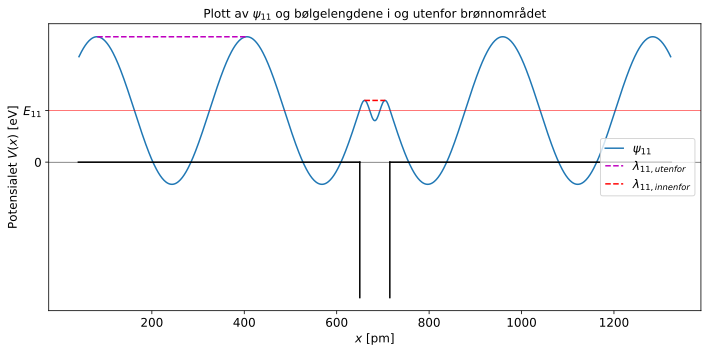

In [13]:
# Sjekker spesifikt bølgelengden til en psi_11
def finding_wavelength():
    idx = argrelextrema(psi[:,10], np.greater)[0]
    return idx

def plot6():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    index = finding_wavelength()
    
    sl = 30 # slice
    plt.plot(x[sl:-sl], psi[sl:-sl,10]/1.2e22+E[10], label=r'$\psi_{11}$')
    plt.plot(x[index[:2]], psi[index[:2],10]/1.2e22+E[10], 'm--', label=r'$\lambda_{11, utenfor}$')
    plt.plot(x[index[2:4]], psi[index[2:4],10]/1.2e22+E[10], 'r--', label=r'$\lambda_{11, innenfor}$')
    
    
    
    plt.title(r"Plott av $\psi_{11}$ og bølgelengdene i og utenfor brønnområdet")
    plt.plot((L*sl/N, (L - w)/2), (0,0), 'k-')
    plt.plot(((L + w)/2, L*(1 - sl/N)), (0,0), 'k-')
    plt.plot(((L - w)/2, (L - w)/2), (V0/20,0), 'k-')
    plt.plot(((L + w)/2, (L + w)/2), (V0/20,0), 'k-')
    plt.axhline(0, linewidth=0.5, color='black')
    plt.axhline(E[10], linewidth=0.5, color='red')
    plt.xlabel(r'$x$ [pm]')
    plt.ylabel(r'Potensialet $V(x)$ [eV]')
    plt.xticks([0.2e-9,0.4e-9,0.6e-9,0.8e-9,1.0e-9,1.2e-9], [200, 400, 600, 800, 1000, 1200])
    plt.yticks([0, E[10]],
              [0, r'$E_{11}$'])
    plt.legend(loc='right')
    
    plt.show()
    return

def kinetic_energy(lambd):
    return 2/m*((np.pi * hBar)/lambd)**2

def show_lambda_result():
    index = finding_wavelength()
    lambda_out = x[index[1]] - x[index[0]]
    lambda_in = x[index[3]] - x[index[2]]
    kin_o = kinetic_energy(lambda_out)
    kin_i = kinetic_energy(lambda_in)
    
    print("lambda_11(utenfor):  %.2f" % (lambda_out*1e10), "Å")
    print("lambda_11(innenfor): %.2f" % (lambda_in*1e10), "Å")
    print()
    print("Kinetisk energi beregnet ved lambda_11:")
    print("K_utenfor:  %.2f" % (kin_o/e), "eV")
    print("K_innenfor: %.2f" % (kin_i/e), "eV")
    print()
    print("Numerisk:")
    print("K_utenfor:  E_11 - 0  = %.2f" % (E[10]/e), "eV")
    print("K_innenfor: E_11 - V0 = %.2f" % ((E[10] - V0)/e), "eV")
    print()
    print("Avvik:")
    dev_o = 100*np.abs(E[10]-kin_o)/E[10]
    dev_i = 100*np.abs(E[10]-V0-kin_i)/(E[10]-V0)
    print("Avvik på K_utenfor: %.2f" % dev_o, "%")
    print("Avvik på K_innenfor: %.2f" % dev_i, "%")
show_lambda_result()
plot6()

Over har jeg valgt ut den 11. tilstanden, av estetiske årsaker mtp. bølgetoppene innenfor brønnområdet. Her har bølgelengdene blitt målt mellom to bølgetopper innenfor, og utenfor brønnområdet. Deretter finner vi elektronets kinetiske energi $K$ vha. de Broglies formel:

$$
    K = \frac{p^2}{2m} = \frac{(2\pi\hbar/\lambda)^2}{2m} = \frac{2\pi^2\hbar^2}{\lambda^2m}.
$$

Resultatet stemmer godt sammenlignet med den numeriske $E_{11} - V(x)$. Avviket er størst innenfor brønnområdet. Det kan være pga at vi regnet med en kortere bølgelengde som medfører større feilutslag.

### b)
Med tre bundne tilstander, og 2 elektroner fyllt opp i hver bunden tilstand, får vi totalt 6 elektroner. Vi har da atomnummer 1, 2, 3, 4, 5 og 6 som gyldige kandidater.
Det totale spinnet for hvert atomnummer blir:

Atomnummer 1: $\quad\pm 1$

Atomnummer 2: $\quad 0$

Atomnummer 3: $\quad\pm 1$

Atomnummer 4: $\quad 0$

Atomnummer 5: $\quad\pm 1$

Atomnummer 6: $\quad 0$

Siden 2 elektroner i samme orbital ikke kan ha samme spinn, så må den ledige spinnverdien velges, og det totale spinnet nøytraliseres når orbitalet fylles opp.

## Oppgave 3

Bindingsenergi til H_2: 17.02 eV
Bindingsenergi til He_2: 8.80 eV


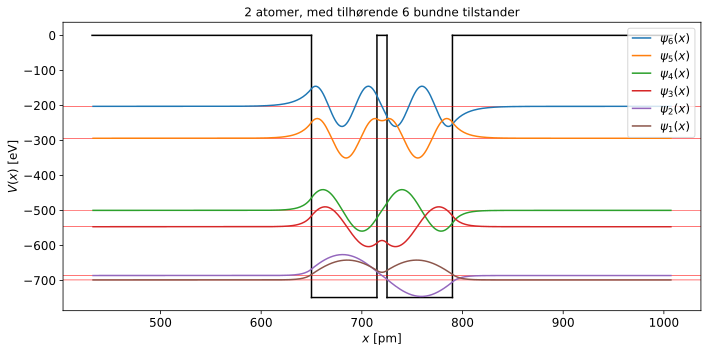

In [14]:
def plot7():
    width = 10
    height = 5
    plt.figure(figsize=(width, height))
    sl = 300
    plt.plot((sl/N*L,10*w), (0,0), color='black')
    plt.plot(((L-b)/2, (L+b)/2), (0,0), color='black')
    plt.plot((L-10*w,L*(1 - sl/N)), (0,0), color='black')
    plt.plot((10*w, (L-b)/2), (V0/e, V0/e), color='black')
    plt.plot(((L+b)/2, L-10*w),(V0/e, V0/e), color='black')
    plt.plot((10*w,10*w),(V0/e,0), color='black')
    plt.plot(((L-b)/2,(L-b)/2), (V0/e,0), color='black')
    plt.plot(((L+b)/2,(L+b)/2),(V0/e,0),color='black')
    plt.plot((L-10*w,L-10*w),(V0/e,0),color='black')
    plt.axhline(E[5]/e, linewidth=0.5, color='red')
    plt.axhline(E[4]/e, linewidth=0.5, color='red')
    plt.axhline(E[3]/e, linewidth=0.5, color='red')
    plt.axhline(E[2]/e, linewidth=0.5, color='red')
    plt.axhline(E[1]/e, linewidth=0.5, color='red')
    plt.axhline(E[0]/e, linewidth=0.5, color='red')
    plt.plot(x[sl:-sl], psi[sl:-sl,5]/1.9e3+E[5]/e, label="$\psi_6(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,4]/1.9e3+E[4]/e, label="$\psi_5(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,3]/1.9e3+E[3]/e, label="$\psi_4(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,2]/1.9e3+E[2]/e, label="$\psi_3(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,1]/1.9e3+E[1]/e, label="$\psi_2(x)$")
    plt.plot(x[sl:-sl], psi[sl:-sl,0]/1.9e3+E[0]/e, label="$\psi_1(x)$")
    plt.legend(loc='best')
    plt.xticks([0.5e-9,0.6e-9,0.7e-9,0.8e-9,0.9e-9,1e-9],[500, 600, 700, 800, 900, 1000])
    plt.xlabel(r'$x$ [pm]')
    plt.ylabel(r'$V(x)$ [eV]')
    plt.title("2 atomer, med tilhørende 6 bundne tilstander")
    
    plt.show()

E, psi, x, L = eigenvalue_eigenvector(2)
E_last, _, _, _ = eigenvalue_eigenvector(1)

ave_bond_enthalpy_hydrogen = 2*(E_last[0] - E[0])/e
ave_bond_enthalpy_helium = 2*(2*E_last[0] - (E[0] + E[1]))/e
print("Bindingsenergi til H_2: %.2f" % ave_bond_enthalpy_hydrogen, "eV")
print("Bindingsenergi til He_2: %.2f" % ave_bond_enthalpy_helium, "eV")
plot7()

Bindingsenergien til $\mathrm{H_2}$ er ca. $4,5$ eV, mens $\mathrm{He_2}$ som praktisk talt ikke bindes, har bindingsenergien $9,1\cdot 10^{-4}$ eV. Ovenfor ser vi at bindingsenergien til $\mathrm{H_2}$ er av samme størrelsesorden, men ca fire ganger så stor, selv om den nukleære avstanden mellom atomene er satt til 75 pm ($b+w$).



## Oppgave 4

In [15]:
def plot8():
    sl = 1
    
    plt.plot((L*sl/N,10*w),(0,0), linewidth=0.3, color='black')
    plt.plot((L*(1-sl/N),L-10*w),(0,0), linewidth=0.3, color='black')
    if Nw % 2:
        plt.plot(((L-w)/2,(L+w)/2), (V0/e,V0/e), linewidth=0.3, color='black')
        plt.plot(((L-w)/2,(L-w)/2),(V0/e,0), linewidth=0.3, color='black')
        plt.plot(((L+w)/2,(L+w)/2),(V0/e,0), linewidth=0.3, color='black')
        for i in range(Nw//2):
            plt.plot(((L+w)/2+i*(w+b), (L+w)/2+b+i*(w+b)),(0,0), linewidth=0.3, color='black')
            plt.plot(((L+w)/2+b+i*(w+b), (L+w)/2+b+i*(w+b)),(0,V0/e), linewidth=0.3, color='black')
            plt.plot(((L+w)/2+b+i*(w+b), (L+w)/2+b+w+i*(w+b)),(V0/e,V0/e), linewidth=0.3, color='black')
            plt.plot(((L+w)/2+b+w+i*(w+b), (L+w)/2+b+w+i*(w+b)),(V0/e,0), linewidth=0.3, color='black')
            
            plt.plot(((L-w)/2-i*(w+b), (L-w)/2-b-i*(w+b)),(0,0), linewidth=0.3, color='black')
            plt.plot(((L-w)/2-b-i*(w+b), (L-w)/2-b-i*(w+b)),(0,V0/e), linewidth=0.3, color='black')
            plt.plot(((L-w)/2-b-i*(w+b), (L-w)/2-b-w-i*(w+b)),(V0/e,V0/e), linewidth=0.3, color='black')
            plt.plot(((L-w)/2-b-w-i*(w+b), (L-w)/2-b-w-i*(w+b)),(V0/e,0), linewidth=0.3, color='black')
    elif Nw > 0:
        plt.plot(((L-b)/2,(L+b)/2), (0,0), linewidth=0.3, color='black')
        for i in range(Nw//2):
            plt.plot(((L+b)/2+i*(w+b),(L+b)/2+i*(w+b)), (V0/e,0), linewidth=0.3, color='black')
            plt.plot(((L-b)/2-i*(w+b),(L-b)/2-i*(w+b)), (V0/e,0), linewidth=0.3, color='black')
            plt.plot(((L+b)/2+w+i*(w+b),(L+b)/2+w+i*(w+b)), (V0/e,0), linewidth=0.3, color='black')
            plt.plot(((L-b)/2-w-i*(w+b),(L-b)/2-w-i*(w+b)), (V0/e,0), linewidth=0.3, color='black')
            
            plt.plot(((L+b)/2+i*(b+w),(L+b)/2+i*(b+w)+w),(V0/e,V0/e), linewidth=0.3, color='black')
            plt.plot(((L-b)/2-i*(b+w),(L-b)/2-i*(b+w)-w),(V0/e,V0/e), linewidth=0.3, color='black')
            if i != Nw//2-1:
                plt.plot(((L+b)/2+w+i*(b+w),(L+b)/2+w+i*(b+w)+b),(0,0), linewidth=0.3, color='black')
                plt.plot(((L-b)/2-w-i*(b+w),(L-b)/2-w-i*(b+w)-b),(0,0), linewidth=0.3, color='black')
    
    for i in range(3*Nw):
        plt.axhline(E[i]/e, color='red', linewidth=0.1)
    
    E_highest = E[2*Nw-1]/e
    E_next = E[2*Nw]/e
    
    plt.plot((10*w,10*w),(E_next,E_highest), \
             color='orange', linewidth=2, label=r'Båndgap $E_\mathrm{2N_w+1}-E_\mathrm{2N_w}$')
    plt.plot((L*sl/N, L*(1-sl/N)),(E_highest,E_highest), \
             color='blue', linewidth=1, label=r'$E_\mathrm{Høyest}$')
    
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$V(x)$ [eV]')
    plt.legend(loc='best')
    print("De elektronene med høyest energi når hvert atom består av 4 elektroner: %.2f" % E_highest, "eV")
    print("Båndgap = %.2f" % (E_next-E_highest), "eV")
    plt.show()

def plot9():
    Nw_arr = 2 + np.arange(49)
    n = Nw_arr.size
    E_1 = np.zeros(n)
    E_2 = np.zeros(n)
    E_3 = np.zeros(n)
    for i in range(n):
        E, _1, _2, _3 = eigenvalue_eigenvector(Nw_arr[i], full_computation=False)
        E_1[i] = (E[Nw_arr[i]-1] - E[0])/e
        E_2[i] = (E[2*(Nw_arr[i])-1] - E[Nw_arr[i]])/e
        E_3[i] = (E[3*(Nw_arr[i])-1] - E[2*Nw_arr[i]])/e
    plt.plot(Nw_arr, E_3, 'm.', markersize=6, label=r'$E_\mathrm{3N_w} - E_{\mathrm{2N_w}+1}$')
    plt.plot(Nw_arr, E_2, 'b.', markersize=6, label=r'$E_\mathrm{2N_w} - E_{\mathrm{N_w}+1}$')
    plt.plot(Nw_arr, E_1, 'r.', markersize=6, label=r'$E_\mathrm{N_w} - E_1$')
    plt.axhline(186,color='magenta', linewidth=1)
    plt.axhline(95,color='blue', linewidth=1)
    plt.axhline(24,color='red', linewidth=1)
    plt.yticks([0,24,95,186])
    plt.ylabel(r'Båndbredden [eV]')
    plt.xlabel(r'Antall atomer $\mathrm{N_w}$')
    plt.legend(loc='upper left')

### a)
Ved å sette antallet atomer `Nw = 5` eller `Nw = 10`, kan vi verifisere at vi får $N_w$ energinivåer omkring hvert atomære energinivå.

### b)
I det siste plottet ser vi båndbredden målt som funksjon av $N_w$, fra 2 til 50. Båndbreddene ender opp med å ligge rundt verdiene 24, 95 og 186 eV.

### c)
Båndgapet ser vi både plottet og printet ut under, og ligger langt over 3 eV. Vi kan konkludere med at krystallen her er en *isolator*.

De elektronene med høyest energi når hvert atom består av 4 elektroner: -475.91 eV
Båndgap = 145.42 eV


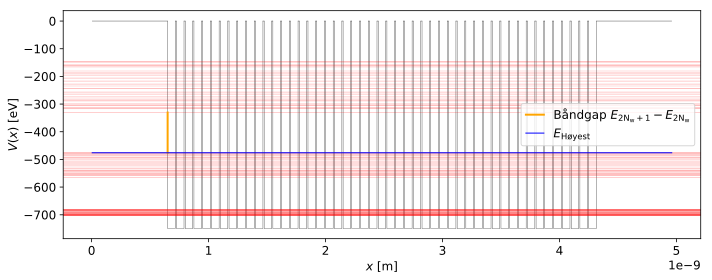

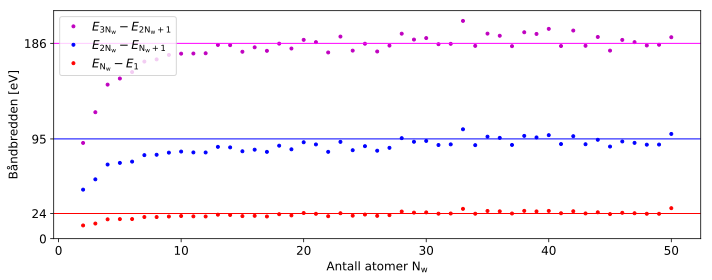

In [16]:
Nw = 49
E, psi, x, L = eigenvalue_eigenvector(Nw)

plot8()
plot9()

### d)

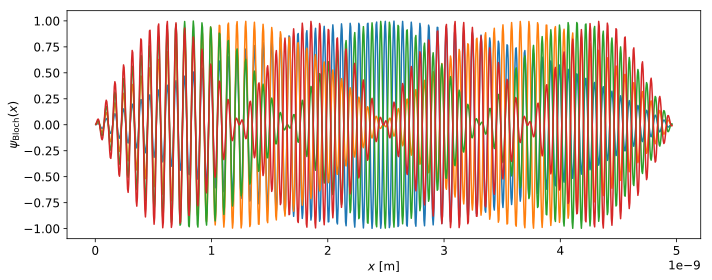

In [17]:
def bloch():
    a = b + w # gitterkonstant
    psi_Bloch = np.zeros((N,N))
    for i in range(Nw):
        k_i = (i+1)*np.pi/L
        psi_Bloch[:,i] = np.sin(k_i * x)*np.sin(2*np.pi/a * x)
    
    plt.plot(x, psi_Bloch[:,0])
    plt.plot(x, psi_Bloch[:,1])
    plt.plot(x, psi_Bloch[:,2])
    plt.plot(x, psi_Bloch[:,3])
    plt.ylabel(r'$\psi_\mathrm{Bloch}(x)$')
    plt.xlabel(r'$x$ [m]')
bloch()